In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
from nodepy import rk
from IPython.display import clear_output
import sys


rk4 = rk.loadRKM('RK44').__num__()
ssp3 = rk.loadRKM('SSP33').__num__()
ssp2 = rk.loadRKM('SSP22').__num__()
bs5 = rk.loadRKM('BS5').__num__()

A22= np.array([[0,0],[0.5,0]])
b22= np.array([0,1])
rk2= rk.ExplicitRungeKuttaMethod(A22,b22)

A31= np.array([[0,0,0], [2/3,0,0], [1/3,1/3,0]])
b31= np.array([1/4, 0, 3/4])
rk31=  rk.ExplicitRungeKuttaMethod(A31,b31)
rk31.bhat= np.array([1/4, 3/8, 3/8])



#base_methods= [ssp2, ssp3, rk4, bs5]
base_methods= [rk2, rk31, rk4, bs5]

#base_method_labels= ["SSPRK(2,2)","SSPRK(3,3)", "RK(4,4)", "BSRK(8,5)"]
base_method_labels= ["RK(2,2)","RK(3,3)", "RK(4,4)", "BSRK(8,5)"]

types= ["RK", "RRK", "RFRK"]

k= np.zeros((4,8))
k[0,:]= [1,-1,0,0,0,0,0,0]
k[1,:]= [2,-1,-1,0,0,0,0,0]
k[2,:]= [1,2,-2,-1,0,0,0,0]
k[3,:]= [2,-1,-1,0,0,0,0,0]






In [22]:
colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#F0E442']
#linestyles = ['-', '--', '-.', ':', "-", "--", "-."]
linestyles = ['-', '--', '-.', ':', (5, (10, 3)),(0, (3, 1, 1, 1))]
markers = ['o','D','X','s','v',"P"]

In [23]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 25}

import matplotlib
matplotlib.rc('font', **font)

#plt.rc("text", usetex=True)
plt.rc("legend", fontsize="medium", fancybox=True, framealpha=0.5)

plt.rcParams["mathtext.fontset"] = "cm"

In [24]:
# Required functions for Euler's equation
# Definition of the RHS Function:
def f(u):
    # left and right values
    ul = np.zeros(np.size(u)+1)
    ul[1:] = u; ul[0] = u[-1]
    ur = np.zeros_like(ul)
    ur[:-1] = u; ur[-1] = u[0]
    # compute numerical fluxes
    mu = 0
    
    fluxes = (ul * ul + ul * ur + ur * ur) /6 - mu*(ur-ul)
    # compute flux differences
    fluxdiff = -(fluxes[1:] - fluxes[:-1]) / dx
    return fluxdiff



def G_1(u):
    
    return 0.5*np.dot(u,u)

def dG_1(u):
    return u






def rgam(gamma,u,inc1,E1_old, est):
    gamma1 = gamma
    uprop = u + gamma1*inc1 
    E1 = G_1(uprop)

    return E1-E1_old - (gamma1+1)*est

def rgam_RF(eps,dt, u_tilde, search1, E1_old, est):
    
    
    uprop = u_tilde + dt* eps* search1 
    E1 = G_1(uprop)

    return E1-E1_old - est


def proj_distance(k_0, s, F, dt, u_tilde, E1_old, est):

    no_inv = 1; eps0 = 0.1
    
    
    k_01= k_0.copy()
    

    search_01= sum([k_01[i]*F[i] for i in range(s)])/np.linalg.norm(sum([k_01[i]*F[i,:] for i in range(s)]))
    #search_02= sum([k_02[i]*F[i] for i in range(s)])/np.linalg.norm(sum([k_02[i]*F[i,:] for i in range(s)]))

    eps, info, ier, mesg = fsolve(rgam_RF,eps0,args=(dt, u_tilde,search_01,E1_old, est),full_output=True)
    #print('mesg: ', mesg)
 

    distance= np.linalg.norm(dt*eps* search_01 )
    #print('distance_opt: ', distance)
    #print('k_1 optimized: ', k_01)
    #print('k_2 optimized: ', k_02)
    return distance

    

def Angle_between(v1, v2):
    
    V1= v1/np.linalg.norm(v1)


    
    V2= v2/np.linalg.norm(v2)

    return (180/np.pi)* np.arccos(np.dot(V1, V2))



In [25]:
def project_direction(u, F):
    s= np.size(F[:, 0])
    n= np.size(F[0, :])

    Normals= np.zeros((1, n))




    for i in range(s):
        normal = F[i , :].copy()
        for j in range(np.size( Normals[:, 0] )):

            normal -= np.dot(normal, Normals[j, :])* Normals[j, :]

        
        
        if np.linalg.norm(normal) > 1.e-7:
            normal= normal / np.linalg.norm(normal)

            Normals= np.append(Normals, np.reshape(normal.copy(), (1,len(normal))), axis=0)
            

    
    
 
    
    u_projected= np.zeros(n)
    for i in range(np.size( Normals[:, 0] )):
        #print('dot(u, Normals): ',np.dot(u, Normals[i, :]))
        u_projected += np.dot(u, Normals[i, :])* Normals[i, :]

    #print('optimized deg:', (180/np.pi)* np.arccos(np.dot(u, u_projected)/ (np.linalg.norm(u)* np.linalg.norm(u_projected))))

    return u_projected
    

Definition of the general integration function

# Base RK

In [26]:
# Compute solution with baseline RK methods
def compute_sol_without_relaxation(Mthdname,rkm, dt, f, T, u0,t0): 
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    steps = 0
    
    while t < T and not np.isclose(t, T):
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
        inc = dt*sum([rkm.b[i]*F[i] for i in range(s)])    
        unew = uu[-1]+inc; t+= dt
        tt = np.append(tt, t)
        steps +=1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0)  
        #print("Method = Baseline %s: Step number = %d (time = %1.2f)"%(Mthdname,steps,tt[-1]))
    return tt, uu

# RRK

In [27]:
def compute_relaxation(Mthdname,rkm, dt, f, T, u0, t0):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    
    Gamma = np.array([]); 
    Gamma = np.append(Gamma, 0)
    
    no_inv = 1; gamma0 = 1
    Inv1_change= np.array([]); 

    proj_length= []

    proj_angle= []

   
    
    errs = 0; steps = 0

    n=0 #test

    
    
    while t < T and not np.isclose(t, T):

        n+=1 #test
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
            
        inc1 = dt*sum([rkm.b[i]*F[i] for i in range(s)])

        est= dt* sum(rkm.b[i]*np.dot(y[i], F[i]) for i in range(s) )
        print('est: ', est)
       
        
        wr_unew = uu[-1] + inc1; E1_old = G_1(uu[-1]) 
        
        gamma, info, ier, mesg = fsolve(rgam,gamma0,args=(wr_unew,inc1,E1_old, est),full_output=True)

       
        print('gamma: ',gamma)

        
        

        
    
        
        

        numer = 2 * sum(rkm.b[i] * rkm.A[i, j] * np.dot(F[i], F[j]) \
                            for i in range(s) for j in range(s))
        
        denom = sum(rkm.b[i] * rkm.b[j] * np.dot(F[i], F[j]) for i in range(s) for j in range(s))

        print('numer: ', numer)
        print('denom: ', denom)

        gam = numer / denom -1
        print('1+gam: ', 1+gam)

        gamma1= gam

        



      



        
        
        unew =  wr_unew + gamma1*inc1 ; 
        
        t+=(1+gamma1)*dt
        #t+= dt # IDT - RRK
        
        E1_new= G_1(unew)
       
        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0) 
        Gamma = np.append(Gamma, gamma1);

        Inv1_change= np.append(Inv1_change, E1_new-E1_old) ; 

        proj_length= np.append(proj_length, np.linalg.norm(gamma1*inc1 ))

        proj_angle= np.append(proj_angle, Angle_between(gamma1*inc1 , dG_1(wr_unew)) )
        
        
        #print("Method = Relaxation %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old))

    return tt, uu, Gamma,  proj_length, proj_angle

# Quasi-Orthogonal Projection

In [28]:
def compute_sol_QO(Mthdname,rkm, dt, f, T, u0, t0):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    
    Eps1 = np.array([]); 
    Eps1 = np.append(Eps1, 0)
    
    no_inv = 1; eps0 = 1
    Inv1_change= np.array([]); 

    proj_length= []

    proj_angle= []

   
    
    errs = 0; steps = 0

    n=0 #test

    
    
    while t < T and not np.isclose(t, T):


        n+=1 #test
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
            
        inc1 = dt*sum([rkm.b[i]*F[i] for i in range(s)])

        est= dt* sum(rkm.b[i]*np.dot(y[i], F[i]) for i in range(s) )
        print('est: ', est)
       
        
        wr_unew = uu[-1] + inc1; E1_old = G_1(uu[-1]) 


        search = project_direction (dG_1(wr_unew), F) # projects dG_1(wr_unew) to the space created by stage derivative vectors
        if np.linalg.norm(search) < 1.e-5:
            print('Search close to zero')

        search= search /np.linalg.norm(search)

       
        
            


        
        
        eps, info, ier, mesg = fsolve(rgam_RF,eps0,args=(dt, wr_unew,search,E1_old, est),full_output=True)
        
      
       

        
        

        
    
        

        
        
        unew =   wr_unew + dt*eps*search  ; t+=dt
        E1_new= G_1(unew)
       
        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0) 
        Eps1 = np.append(Eps1, eps);

        Inv1_change= np.append(Inv1_change, E1_new-E1_old) ;

        proj_length= np.append(proj_length, np.linalg.norm(dt*eps*search))

        proj_angle= np.append(proj_angle, Angle_between(eps*search  , dG_1(wr_unew)) )
        
        #print("Method = Orthogonal %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old))

    return tt, uu, Eps1 , proj_length, proj_angle

# Directional method

In [29]:
def compute_sol_D(Mthdname,rkm, dt, f, T, u0, t0):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    b= rkm.b
    
    Eps1 = np.array([]); 
    Eps1 = np.append(Eps1, 0)
    
    no_inv = 1; eps0 = 1
    Inv1_change= np.array([]); 

    proj_length= []

    proj_angle= []
    

   
    
    errs = 0; steps = 0

    n=0 #test

    
    
    while t < T and not np.isclose(t, T):

        n+=1 #test
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
            
        inc1 = dt*sum([rkm.b[i]*F[i] for i in range(s)])

        est= dt* sum(rkm.b[i]*np.dot(y[i], F[i]) for i in range(s) )
        print('est: ', est)
       
        
        wr_unew = uu[-1] + inc1; E1_old = G_1(uu[-1]) 


        search= sum([b[i]*F[i] for i in range(s)]) - F[0]

        search1= search/ np.linalg.norm(search) # For this problem they become equal

       
        
            


        
        
        eps, info, ier, mesg = fsolve(rgam_RF,eps0,args=(dt, wr_unew,search1,E1_old, est),full_output=True)
        
        print('eps: ', eps)


       

        
        

        
    
        

        
        
        unew =   wr_unew + dt*eps*search1  ; t+=dt
        E1_new= G_1(unew)
       
        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0) 
        Eps1 = np.append(Eps1, eps);

        Inv1_change= np.append(Inv1_change, E1_new-E1_old) ; 

        proj_length= np.append(proj_length, np.linalg.norm(dt*eps*search1))

        proj_angle= np.append(proj_angle, Angle_between(eps*search1  , dG_1(wr_unew)) )
        
        print("Method = Orthogonal %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old))

    return tt, uu, Eps1 , proj_length, proj_angle

# Example case 4

In [30]:


N = 50

x, dx = np.linspace(-1, 1, N, endpoint=False, retstep=True)
x = x + 0.5*dx # x are the mean values of each cell
u0 = np.exp(-30*x**2) 

u=u0


# RK 

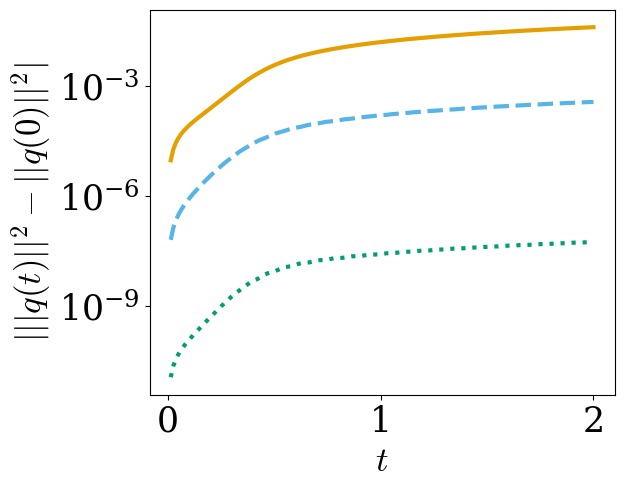

<Figure size 640x480 with 0 Axes>

In [31]:
dt= 0.3* dx
t_final= 2

mu= 0.0

#linestyles = ['-', '--', '-.', ':', (5, (10, 3)),(0, (3, 1, 1, 1))]
linestyles = ['-', '--', ':', ':', (5, (10, 3)),(0, (3, 1, 1, 1))]

base_methods= [ rk31, rk4, bs5]

base_method_labels= ["RK(3,3)", "RK(4,4)", "BSRK(8,5)"]

fig=plt.figure(figsize=(6,5))
for b,base in enumerate(base_methods):

    
    tt, uu= compute_sol_without_relaxation("rk",base, dt, f, t_final, u0,t0=0)
    
    E= np.zeros_like(tt)
    for i in range(len(tt)):
        E[i]= np.dot(uu[i, :], uu[i, :])
        
    plt.yscale("log")
    plt.plot(tt[1:], np.abs(E[1:]-E[0]), color=colors[b], linestyle=linestyles[b],lw=3, label=base_method_labels[b])
    
plt.xlabel("$t$")
plt.ylabel("$|||q(t)||^2- ||q(0)||^2|$")


#plt.savefig("Figures/Burgers_evol_RK.png",bbox_inches="tight")

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=3)
#plt.savefig("./Figures/Burgers_evol_legend.png",bbox_inches="tight")


plt.show()  






# RRK conservative

est:  -9.631402973396112e-18
gamma:  [3.77951612e-10]
numer:  528.8911272931554
denom:  528.8911270932537
1+gam:  1.0000000003779639


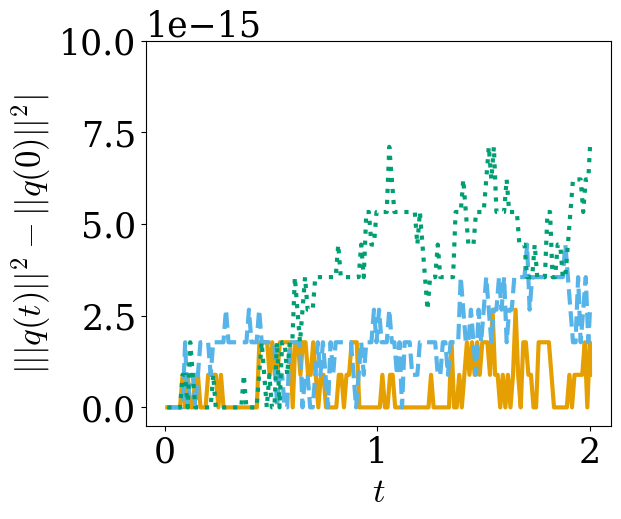

In [32]:
dt= 0.3* dx
t_final= 2
mu= 0.0




fig=plt.figure(figsize=(6,5))
for b,base in enumerate(base_methods):
    
    
    tt, uu, Gamma,  Inv1_change, proj_angle= compute_relaxation('RRK',base, dt, f, t_final, u0, t0=0)
    
    E= np.zeros_like(tt)
    for i in range(len(tt)):
        E[i]= np.dot(uu[i, :], uu[i, :])
        
    plt.plot(tt[1:], np.abs(E[1:]-E[0]),linestyle=linestyles[b], color=colors[b] ,lw=3, label=base_method_labels[b])

plt.ylim([-.5e-15,1e-14])

plt.xlabel("$t$")
plt.ylabel("$|||q(t)||^2- ||q(0)||^2|$")



#plt.savefig("Figures/Burgers_evol_RRK.png",bbox_inches="tight")


plt.show() 

# QO_RK conservative

est:  -8.084815004586583e-18


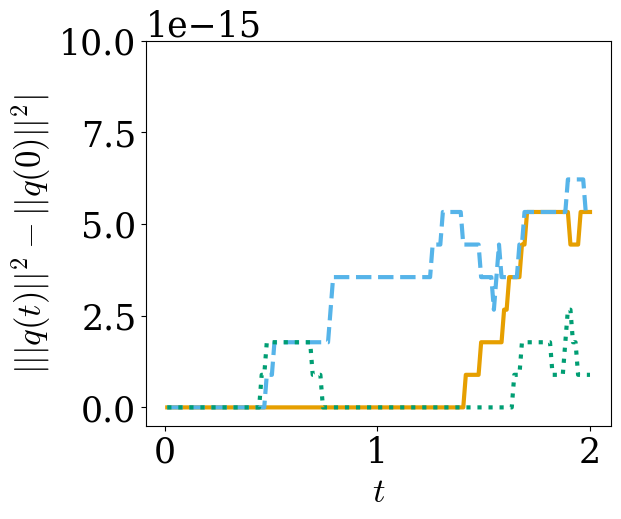

In [33]:
dt= 0.3* dx
t_final= 2
mu= 0.0

fig=plt.figure(figsize=(6,5))
for b,base in enumerate(base_methods):
    
    
    
    tt, uu, Eps, Inv_change, proj_angle= compute_sol_QO("RFRK",base, dt, f, t_final, u0,t0=0)
    
    E= np.zeros_like(tt)
    for i in range(len(tt)):
        E[i]= np.dot(uu[i, :], uu[i, :])
        
    plt.plot(tt[1:], np.abs(E[1:]-E[0]), color=colors[b],linestyle=linestyles[b] ,lw=3, label=base_method_labels[b])

plt.ylim([-.5e-15,1e-14])

plt.xlabel("$t$")
plt.ylabel("$|||q(t)||^2- ||q(0)||^2|$")


#plt.savefig("Figures/Burgers_evol_QO_RK.png",bbox_inches="tight")


plt.show() 

# R_RK  Proj Degree

est:  1.998352813421173e-18
gamma:  [1.1967909e-09]
numer:  90.94705063924312
denom:  90.94705053039237
1+gam:  1.0000000011968584


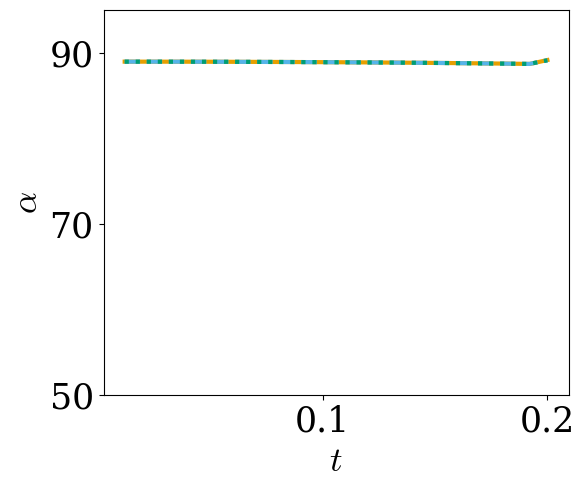

<Figure size 640x480 with 0 Axes>

In [34]:
dt= 0.3* dx
t_final= 0.2
mu= 0.0

fig=plt.figure(figsize=(6,5))
for b,base in enumerate(base_methods):
    
    
    tt, uu, Gamma,  proj_length, proj_angle = compute_relaxation('RRK',base, dt, f, t_final, u0, t0=0)
    
    E= np.zeros_like(tt)
    for i in range(len(tt)):
        E[i]= np.dot(uu[i, :], uu[i, :])
        
    #plt.yscale("log")
    plt.plot(tt[1:], proj_angle, color=colors[b] ,linestyle=linestyles[b],lw=3, label=base_method_labels[b])

plt.ylim([50,95])
plt.yticks([ 50,70, 90])

plt.xlabel("$t$")
plt.ylabel("$\\alpha$")

#plt.savefig("Figures/Burgers_proj_angle_RRK.png",bbox_inches="tight")

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=3)
#plt.savefig("./Figures/Burgers_proj_angle_legend.png",bbox_inches="tight")


plt.show()

# QO_projection Proj deg

est:  2.2373705967144162e-18


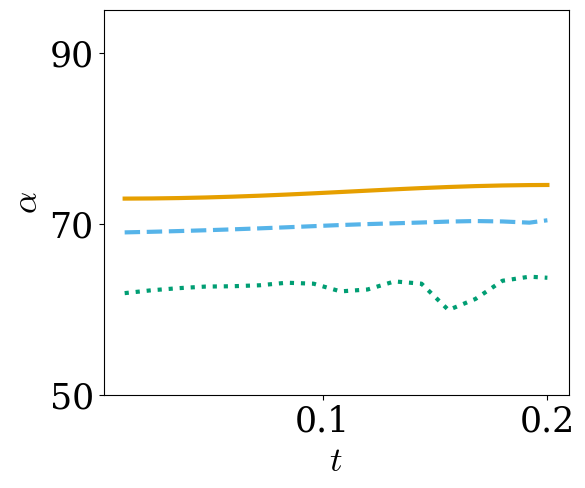

In [35]:
dt= 0.3* dx
t_final= 0.2
mu= 0.0

fig=plt.figure(figsize=(6,5))
for b,base in enumerate(base_methods):
    
    
    tt, uu, Gamma,  proj_angle, proj_angle= compute_sol_QO('RRK',base, dt, f, t_final, u0, t0=0)
    
    E= np.zeros_like(tt)
    for i in range(len(tt)):
        E[i]= np.dot(uu[i, :], uu[i, :])
        
    plt.plot(tt[1:], proj_angle, color=colors[b] ,linestyle=linestyles[b],lw=3, label=base_method_labels[b])

plt.ylim([50,95])
plt.yticks([ 50,70, 90])

plt.xlabel("$t$")
plt.ylabel("$\\alpha$")

#plt.savefig("Figures/Burgers_proj_angle_QO_RK.png",bbox_inches="tight")


plt.show()

# QO change in linear ivnarinat

est:  2.2373705967144162e-18


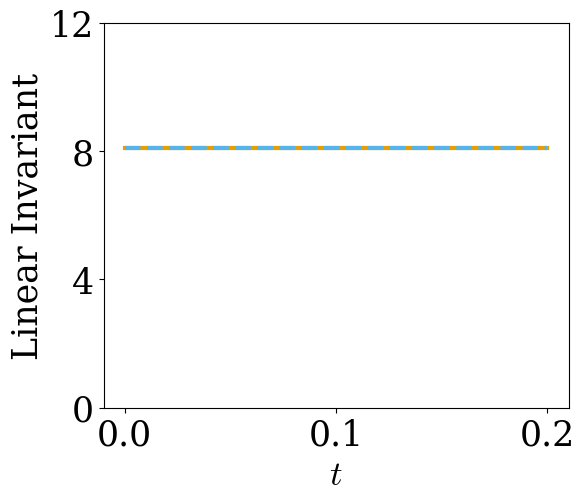

In [36]:
dt= 0.3* dx
t_final= 0.2
mu= 0.0

fig=plt.figure(figsize=(6,5))
for b,base in enumerate(base_methods[1:]):
    
    
    tt, uu, Gamma,  proj_angle, proj_angle= compute_sol_QO('RRK',base, dt, f, t_final, u0, t0=0)
    
    Lin_inv= np.zeros_like(tt)
    for i in range(len(tt)):
        Lin_inv[i]= np.sum(uu[i, :])
        
    #plt.yscale("log")
    plt.plot(tt, Lin_inv, color=colors[b] ,linestyle=linestyles[b],lw=3, label=base_method_labels[b+1])


plt.ylim([0,12])
plt.yticks([0,4,  8, 12])

plt.xlabel("$t$")
plt.ylabel("Linear Invariant")
#plt.title('Relaxation-RK methods' , fontsize= 18)

plt.savefig("Figures/Burgers_QO_RK_lin_inv.png",bbox_inches="tight")

#plt.grid()
#plt.legend(fontsize= 12)
plt.show()

# Directional method

est:  2.6018204113975092e-18
eps:  [-7.05728413e-10]
Method = Orthogonal RRK: At step number = 17 (time = 0.20), integer flag = 5 and E1-E1_old = 0.000000 



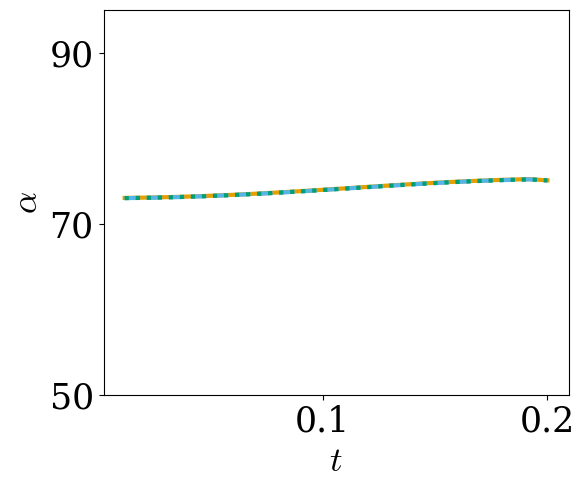

In [37]:
dt= 0.3* dx
t_final= 0.2
mu= 0.0

fig=plt.figure(figsize=(6,5))
for b,base in enumerate(base_methods):
    
    
    tt, uu, Gamma,  proj_length, proj_angle= compute_sol_D('RRK',base, dt, f, t_final, u0, t0=0)
    
    E= np.zeros_like(tt)
    for i in range(len(tt)):
        E[i]= np.dot(uu[i, :], uu[i, :])
        
    plt.plot(tt[1:], proj_angle, color=colors[b] ,linestyle=linestyles[b],lw=3, label=base_method_labels[b])

plt.ylim([50,95])
plt.yticks([ 50,70, 90])

plt.xlabel("$t$")
plt.ylabel("$\\alpha$")

#plt.savefig("Figures/Burgers_proj_angle_RF_RK.png",bbox_inches="tight")


plt.show()

# Convergence QO_RK

In [48]:
cfls = 0.3 *0.5**np.arange(7)
# dt= cfls* dx
base_methods= [rk31, rk4, bs5]
base_method_labels= ["RK(3,3)", "RK(4,4)", "BSRK(8,5)"]

t_final=0.2

sols_rk2= []
sols_rk3=[]
sols_rk4=[]
sols_bs8=[]

sols_RFRK_rk2= []
sols_RFRK_rk3=[]
sols_RFRK_rk4=[]
sols_RFRK_bs8=[]

lines= []


errors_b= np.zeros((len(base_methods), len(cfls)))

for b,base in enumerate(base_methods):
    
    sols_rk= []
    for cfl in cfls:
        
        dt= cfl*dx

        tt, uu= compute_sol_without_relaxation("rk",base, dt, f, t_final, u0,t0=0)
        sols_rk.append(uu[-1, :])
            
    errors= []
    ref = sols_rk[-1]
    for i in range(len(sols_rk)):
       
        errors_b[b, i]= np.sum(np.abs(ref - sols_rk[i]))

        
# -------------------------------------------------------------

errors_qo= np.zeros((len(base_methods), len(cfls)))
for b,base in enumerate(base_methods):
    
    sols_qo= []
    for cfl in cfls:
        
        dt= cfl*dx

        tt_qo, uu_qo, Eps, Inv_change, inv_angle= compute_sol_QO("RFRK",base, dt, f, t_final, u0,t0=0)
        #tt, uu= compute_sol_without_relaxation("rk",base, dt, f, t_final, u0,t0=0)
        sols_qo.append(uu_qo[-1, :])
        
            
    errors= []
    ref = sols_qo[-1]
    for i in range(len(sols_qo)):
        
        errors_qo[b, i]= np.sum(np.abs(ref - sols_qo[i]))




est:  3.0083649426111055e-20


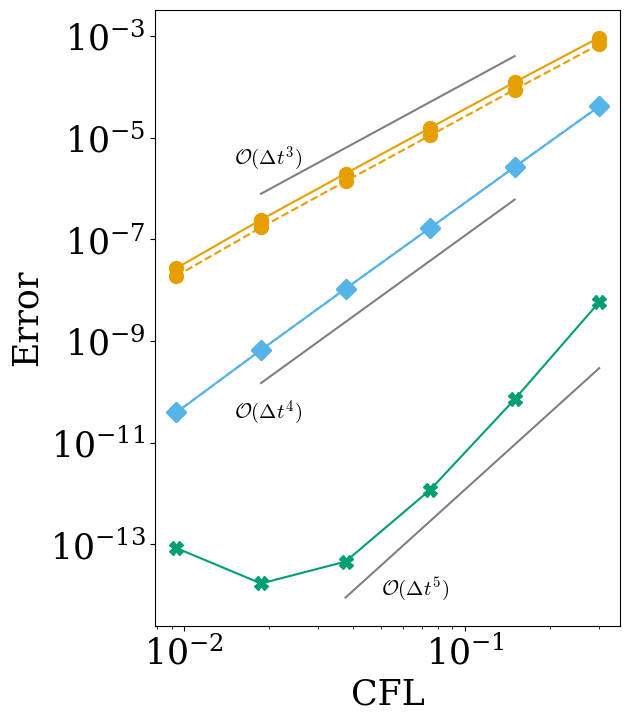

<Figure size 640x480 with 0 Axes>

In [49]:
plt.figure(figsize=(6,8))

for b,base in enumerate(base_methods):
    
    

    plt.loglog(cfls[:-1], errors_b[b,:-1], linestyle='-',color=colors[b],marker=markers[b],markersize=10, label=base_method_labels[b] )
        
# -------------------------------------------------------------


for b,base in enumerate(base_methods[1:]):
    
   

    plt.loglog(cfls[:-1], errors_qo[b,:-1], linestyle='--',color=colors[b],marker=markers[b],markersize=10 )


        
plt.plot(cfls[1:-2], 12.0e-2*cfls[1:-2]**3,  color="gray")
plt.annotate(r"$\mathcal{O}(\Delta t^3)$", (1.5e-2, 3.0e-6), color="k", fontsize=15)

plt.plot(cfls[1:-2], 12.0e-4*cfls[1:-2]**4,  color="gray")
plt.annotate(r"$\mathcal{O}(\Delta t^4)$", (1.5e-2, 3.0e-11), color="k", fontsize=15)

plt.plot(cfls[0:-3], 12.0e-8*cfls[0:-3]**5,  color="gray")
plt.annotate(r"$\mathcal{O}(\Delta t^5)$", (5e-2, 1.0e-14), color="k", fontsize=15)


plt.xlabel("CFL")
plt.ylabel('Error')
#plt.title('Standard RK4' , fontsize= 18)

#plt.grid()
#plt.legend(fontsize= 14, loc='lower right')
#plt.legend()
plt.yticks([1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 1e-3])



plt.savefig("Figures/Burgers_convergence_QO_RK.png",bbox_inches="tight")


ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=4)
plt.savefig("./Figures/Burgers_convergence_legend.png",bbox_inches="tight")


plt.show()